# Twitter trolls - how Russia meddles with western democracies


## Abstract
Over the last several years there has been an attempt from Russian trolls to spread propaganda and fake news over social media in order to spread political ideas among the general population both nationally and internationally. Can these attempts be regarded as undermining the democracy of the affected countries?

In this project we are going to analyze a great number of these russian tweets and look into their motivations for this meddling. We will mainly look into their overall political goals in the US, and examine how these goals change over time. Have the trolls achieved their goals? We will also look into how the trolls operate and organize themselves, trying to find patterns in the madness. Such patterns can hopefully help the general population to indicate that a tweet is originating from a troll. As the Russian efforts are increasing every year, a solution is needed to defend the democracy.

## Research questions

-Which themes does the propaganda mainly revolve around? About which issues should people be particularly careful not to believe everything they read?
-Words
-most common word
-names
-consensus
-checking most common words in set above 3 characters (most common 4grams)

-Does the trolls advocate for a common political stance in each specific country? If so which leaning do they have? If not, how polarized are the tweets between left leaning and right leaning?
-groupby region, category

-Were the trolls united with a common political leaning in the period after the primaries in the US elections?


-Was the original mission of the Russian trolls for the US election to make sure that Clinton was not elected, or to get Trump elected?

-Are the trolls organized as a unit? Do they interact with each other (retweets, etc)?

-Is there a way for people without a technical background to determine if a tweet is coming from a Russian troll?

## Research questions

IRA russian twitter trolls - Three million tweets amounting to 175 Mb, along with a detailed description of the dataset

This dataset contains around three million tweets and retweets from 2848 unique twitter users. Each tweet has several attributes, some of them are extracted from the tweet itself. For instance the author, content, and time stamp. Other attributes are later added. An example of such attributes is category of the troll, e.g. RightTroll, NewsFeed, etc.

There are many factors that we can examine in the dataset. Looking at given features like timing could be very interesting to find patterns. We also intend to add features, in order to make the dataset more suitable for our analysis. As every data point contains the whole tweet itself, it is possible to perform a broad analysis on the content. This could be used to determine whether a certain person or word is mentioned, and add the overall theming as a feature. Another example of a possible extra feature is stating whether a tweet is a retweet of another troll, unique, or identical to another tweet in the set.

The data set it pretty small so it should be pretty manageable to process with pandas, but spark could also be used.

## Requierements

The second task is to intimately acquaint yourself with the data, preprocess it and complete all the necessary descriptive statistics tasks. We expect you to have a pipeline in place, fully documented in a notebook, and show us that you’ve advanced with your understanding of the project goals by updating its README description.

When describing the data, in particular, you should show (non-exhaustive list):

- That you can handle the data in its size.
- That you understand what’s into the data (formats, distributions, missing values, correlations, etc.).
- That you considered ways to enrich, filter, transform the data according to your needs.
- That you have updated your plan in a reasonable way, reflecting your improved knowledge after data acquaintance. In particular, discuss how your data suits your project needs and discuss the methods you’re going to use, giving their essential mathematical details in the notebook.
- That your plan for analysis and communication is now reasonable and sound, potentially discussing alternatives to your choices that you considered but dropped.

We will evaluate this milestone according to how well these previous steps (or other reasonable ones) have been done and documented, the quality of the code and its documentation, the feasibility and critical awareness of the project.

## Description of second data set: 

- rus_troll_user.csv : Contains user specific features. (nickname, description field, follower count etc.)
- rus_troll_tweet_text.csv: Contains text and language of the given tweet. You will use this if you are doing text classification, sentiment analysis, topic detection etc. 
- rus_troll_tweet_metadata.csv: Contains features that are user specific, but may change tweet to tweet.
- rus_troll_tweet_stats.csv: Contains other (imo important) tweet features

In [1]:
# Add your imports here
import pandas as pd
import numpy as np
import seaborn as sns
from zipfile import ZipFile
from langdetect import detect
import scipy as sp
from pyspark.sql import *
from pyspark.sql.functions import *
%matplotlib inline
from pyspark.sql.types import *
import matplotlib.pyplot as plt
from statistics import median 
import pyspark.sql.functions as func

spark = SparkSession.builder.getOrCreate()


In [2]:
zip_file = ZipFile('russian-troll-tweets.zip')
data = pd.DataFrame()

In [3]:
for i in range(1,9):
    data = data.append(pd.read_csv(zip_file.open("IRAhandle_tweets_"+str(i)+".csv")))
data=data.reset_index()

In [4]:
data.head(5)

,index,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
0,0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,NaN,Right,0,0,RightTroll
1,1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,NaN,Right,0,0,RightTroll
2,2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,RETWEET,Right,0,1,RightTroll
3,3,9.060000e+17,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,NaN,Right,0,0,RightTroll
4,4,9.060000e+17,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,RETWEET,Right,0,1,RightTroll


In [5]:
data = data.drop(columns=["index","harvested_date","new_june_2018","retweet"])
data["post_type"].unique()

array([nan, 'RETWEET', 'QUOTE_TWEET'], dtype=object)

In [6]:
data["publish_date"] =   pd.to_datetime(data["publish_date"], format='%m/%d/%Y\n%H:%M')


In [7]:
data["post_type"] = data["post_type"].fillna("ORIGINAL_TWEET")
data

,external_author_id,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,2017-10-01 19:58:00,1052,9636,253,ORIGINAL_TWEET,Right,RightTroll
1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,2017-10-01 22:43:00,1054,9637,254,ORIGINAL_TWEET,Right,RightTroll
2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,2017-10-01 22:50:00,1054,9637,255,RETWEET,Right,RightTroll
3,9.060000e+17,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,2017-10-01 23:52:00,1062,9642,256,ORIGINAL_TWEET,Right,RightTroll
4,9.060000e+17,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,2017-10-01 02:13:00,1050,9645,246,RETWEET,Right,RightTroll
5,9.060000e+17,10_GOP,"Dan Bongino: ""Nobody trolls liberals better th...",Unknown,English,2017-10-01 02:47:00,1050,9644,247,ORIGINAL_TWEET,Right,RightTroll
6,9.060000e+17,10_GOP,🐝🐝🐝 https://t.co/MorL3AQW0z,Unknown,English,2017-10-01 02:48:00,1050,9644,248,RETWEET,Right,RightTroll
7,9.060000e+17,10_GOP,'@SenatorMenendez @CarmenYulinCruz Doesn't mat...,Unknown,English,2017-10-01 02:52:00,1050,9644,249,ORIGINAL_TWEET,Right,RightTroll
8,9.060000e+17,10_GOP,"As much as I hate promoting CNN article, here ...",Unknown,English,2017-10-01 03:47:00,1050,9646,250,ORIGINAL_TWEET,Right,RightTroll
9,9.060000e+17,10_GOP,After the 'genocide' remark from San Juan Mayo...,Unknown,English,2017-10-01 03:51:00,1050,9646,251,ORIGINAL_TWEET,Right,RightTroll


In [8]:
data.groupby(["region"]).size()


region
Afghanistan                     3319
Austria                            1
Azerbaijan                     98437
Belarus                        29152
Canada                           608
Czech Republic                     7
Denmark                            1
Egypt                            232
Estonia                            1
Finland                           20
France                           942
Germany                        27192
Greece                            91
Hong Kong                          3
India                             22
Iran, Islamic Republic of        541
Iraq                           11202
Israel                          3600
Italy                          13494
Japan                            110
Latvia                             7
Malaysia                        4933
Mexico                            41
Russian Federation             37094
Samoa                             32
Saudi Arabia                       7
Serbia                         

We see from  that there are a lot of regions affected by Russian interference. Not surprisingly tweets in United states account for more than half of our dataset, this comes as no surprise as this meddling has gotten is widely regarded as the most widespread. 

We also see a lot of other regions with a lot of tweets. Azerbaijan, Belarus, Germany, Iraq, Italy, Russia, UAE and UK all have more than 10000 tweets labeled to them. 

It makes a lot of sense that Russia itself is a major target, as one can expect that influencing ones own population is an important way of staying in power, and achieving political goals.  

Azerbaijan is contrary to our expectations the country with the second highest amount of tweets from trolls. Our expectations was that UK, Germany and Italy would be a bigger target as these countries are all part of NATO and as of now the EU. Which all regard Russia as a hostile nation. Weakening the political stability and advocating for leaving such organizations would therefore seem like an obvious goal for

In [9]:
data.groupby(["language","region"]).size()


language    region                   
Albanian    Afghanistan                      1
            Azerbaijan                       3
            Egypt                            1
            Germany                          4
            Italy                            2
            United Arab Emirates             1
            United Kingdom                   9
            United States                  507
            Unknown                         35
Arabic      Afghanistan                   2201
            Azerbaijan                      39
            Belarus                          1
            Canada                           1
            Egypt                           60
            Germany                         14
            Iraq                           187
            Israel                        1478
            Russian Federation               5
            Turkey                           8
            Ukraine                          1
            United Ara

After inspecting some of the tweets we conclude that a lot of the language stamps do not match, the actual tweets. For instance, most of the tweets labeled to our mothertongue Norwegian was English. The same went for different languages, such as those of neighbouring countries like Danish and Swedish. For this reason we decide to discard all tweets in other languages than english, in order to avoid confusion. This also helps keeping the scope of the project limited.

In [10]:
data = data.loc[data['language'] == "English"]
data.head(10)


,external_author_id,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,2017-10-01 19:58:00,1052,9636,253,ORIGINAL_TWEET,Right,RightTroll
1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,2017-10-01 22:43:00,1054,9637,254,ORIGINAL_TWEET,Right,RightTroll
2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,2017-10-01 22:50:00,1054,9637,255,RETWEET,Right,RightTroll
3,9.060000e+17,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,2017-10-01 23:52:00,1062,9642,256,ORIGINAL_TWEET,Right,RightTroll
4,9.060000e+17,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,2017-10-01 02:13:00,1050,9645,246,RETWEET,Right,RightTroll
5,9.060000e+17,10_GOP,"Dan Bongino: ""Nobody trolls liberals better th...",Unknown,English,2017-10-01 02:47:00,1050,9644,247,ORIGINAL_TWEET,Right,RightTroll
6,9.060000e+17,10_GOP,🐝🐝🐝 https://t.co/MorL3AQW0z,Unknown,English,2017-10-01 02:48:00,1050,9644,248,RETWEET,Right,RightTroll
7,9.060000e+17,10_GOP,'@SenatorMenendez @CarmenYulinCruz Doesn't mat...,Unknown,English,2017-10-01 02:52:00,1050,9644,249,ORIGINAL_TWEET,Right,RightTroll
8,9.060000e+17,10_GOP,"As much as I hate promoting CNN article, here ...",Unknown,English,2017-10-01 03:47:00,1050,9646,250,ORIGINAL_TWEET,Right,RightTroll
9,9.060000e+17,10_GOP,After the 'genocide' remark from San Juan Mayo...,Unknown,English,2017-10-01 03:51:00,1050,9646,251,ORIGINAL_TWEET,Right,RightTroll


In [11]:
data.groupby(["region"]).size()

region
Afghanistan                      174
Azerbaijan                      7611
Belarus                          494
Canada                           600
Czech Republic                     2
Denmark                            1
Egypt                             59
Finland                            8
France                            67
Germany                         1285
Greece                            14
Hong Kong                          1
Iran, Islamic Republic of         20
Iraq                             458
Israel                           403
Italy                           1125
Latvia                             3
Malaysia                           4
Mexico                            41
Russian Federation              1143
Serbia                             2
Spain                             72
Sweden                            43
Switzerland                        1
Ukraine                          231
United Arab Emirates             281
United Kingdom                 

Strangely, even after removing all but english-labeled columns we have lot of regions represented in our dataset. After inspecting the english tweets from azerbaijan, we find that most tweets are retweets. We suspect this might be the case for the other non-english speaking countries. We count the number of each tweet type for all represented countries.

In [12]:
data.groupby(["region","post_type"]).size()

region                     post_type     
Afghanistan                ORIGINAL_TWEET         25
                           RETWEET               149
Azerbaijan                 ORIGINAL_TWEET        874
                           RETWEET              6737
Belarus                    ORIGINAL_TWEET        110
                           QUOTE_TWEET             1
                           RETWEET               383
Canada                     ORIGINAL_TWEET        566
                           RETWEET                34
Czech Republic             ORIGINAL_TWEET          2
Denmark                    ORIGINAL_TWEET          1
Egypt                      ORIGINAL_TWEET          6
                           QUOTE_TWEET             1
                           RETWEET                52
Finland                    ORIGINAL_TWEET          8
France                     ORIGINAL_TWEET         45
                           RETWEET                22
Germany                    ORIGINAL_TWEET        642
    

We believe that this might be a potential tool for pushing retweet count of other tweets up, to increase their legitimacy in the eyes of others.

In [13]:
aggregate = data.groupby(["content","post_type"]).size().sort_values(ascending=False)
display(aggregate)

content                                                                                                                                                                                                                                                                                                  post_type     
NewsOne Now Audio Podcast: Bishop E.W. Jackson Calls #BlackLivesMatter Is Movement “Disgraceful”                                                                                                                                                                                                         ORIGINAL_TWEET    214
Honor scores  #sports                                                                                                                                                                                                                                                                                    ORIGINAL_TWEET    130
TV/radio schedule  #sports                        

Interestingly we see that a lot of tweets are the same except for different links. We decide to split on the keyword "http", discard the last part and strip the remianing part, in order to make sure that minor changes are not taken into account.

In [14]:
stripped_data = data
stripped_data["content"]=data["content"].apply(lambda s: str(s).split("https")[0].strip())
aggregate_stripped = data.groupby(["content"]).size().sort_values(ascending=False)
display(aggregate_stripped)


/Users/Skolebruker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


content
                                                                                                                                                8778
Targeted #ISIS accounts                                                                                                                          968
Listen to the title track of the upcoming mashup album #TheFourHorsemen #TheArtOfWar ft #T…                                                      383
'@WarfareWW                                                                                                                                      321
I added a video to a @YouTube playlist                                                                                                           270
I liked a @YouTube video                                                                                                                         261
�                                                                                                 

Top two rows are empty, meaning that they only contained links, we disregard these.

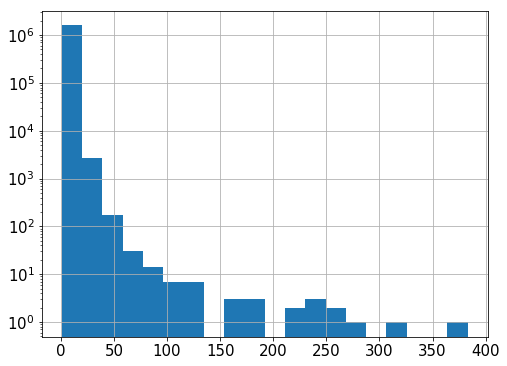

In [15]:
aggregate_stripped.drop(aggregate_stripped.index[[0,1]], inplace=True)
aggregate_stripped.hist(bins=20, figsize=(8,6), xlabelsize=15, ylabelsize=15, log =True)

we see that most tweets are only written once. However, approximately a quarter of the tweets are not unique.

In [16]:
len(data)

2113415

In [17]:
data = data.sort_values("publish_date")

In [18]:
data

,external_author_id,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,account_category
687349,4.437234e+09,CRYSTAL1JOHNSON,Resale homes sales R up. As we learned from th...,United States,English,2012-02-06 20:24:00,4,0,2,ORIGINAL_TWEET,left,LeftTroll
687369,4.437234e+09,CRYSTAL1JOHNSON,Good morning! There is so much we have to be t...,United States,English,2012-02-07 13:24:00,4,0,4,ORIGINAL_TWEET,left,LeftTroll
687391,4.437234e+09,CRYSTAL1JOHNSON,The reality is becoming increasingly pellucid:...,United States,English,2012-02-08 13:37:00,7,0,4,ORIGINAL_TWEET,left,LeftTroll
686933,4.437234e+09,CRYSTAL1JOHNSON,“The content of your character is your choice....,United States,English,2012-02-14 12:45:00,7,1,8,ORIGINAL_TWEET,left,LeftTroll
687259,4.437234e+09,CRYSTAL1JOHNSON,"""Coming together is a beginning. Keeping toget...",United States,English,2012-02-29 14:32:00,7,2,9,ORIGINAL_TWEET,left,LeftTroll
688172,4.437234e+09,CRYSTAL1JOHNSON,What lies behind us and what lies between us a...,United States,English,2012-03-07 14:42:00,7,2,9,ORIGINAL_TWEET,left,LeftTroll
688194,4.437234e+09,CRYSTAL1JOHNSON,"""I immerse my mind with good positive thoughts...",United States,English,2012-03-08 14:25:00,7,2,11,ORIGINAL_TWEET,left,LeftTroll
687494,4.437234e+09,CRYSTAL1JOHNSON,To Follow or Not To Follow: Should Small Busin...,United States,English,2012-03-12 05:32:00,7,2,12,ORIGINAL_TWEET,left,LeftTroll
687603,4.437234e+09,CRYSTAL1JOHNSON,Interest Rates are on the move: the biggest ju...,United States,English,2012-03-16 12:42:00,7,2,14,ORIGINAL_TWEET,left,LeftTroll
687604,4.437234e+09,CRYSTAL1JOHNSON,“My philosophy is that not only r u responsibl...,United States,English,2012-03-16 12:42:00,7,2,13,ORIGINAL_TWEET,left,LeftTroll
